In [33]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

# Canny Edge Detection
## Step 1: Convert Image to Grayscale

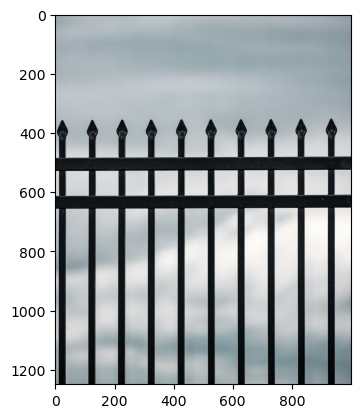

In [34]:
img = cv2.imread('data/fence.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

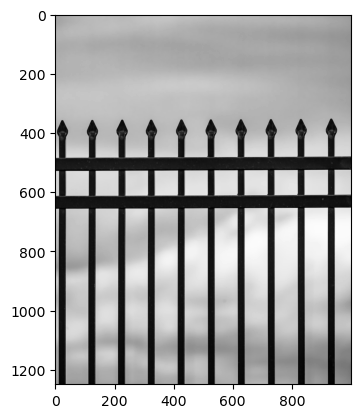

In [35]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2.imwrite('data/fence-gray.jpg', img_gray)
plt.imshow(img_gray, cmap='gray')
plt.show()

## Step 2: Gaussian Blur

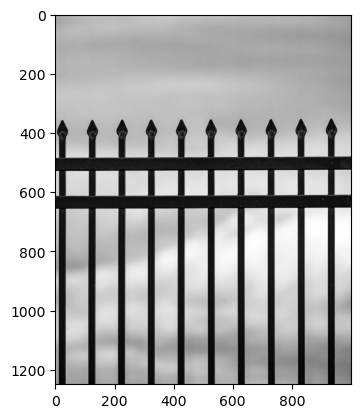

In [36]:
def get_gaussian_filter(shape:tuple[int, int], sigma:float=0.5) -> np.ndarray:
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def gaussian_blur_custom(image:np.ndarray, kernel_size:int, sigma:float=0.5) -> np.ndarray:
    kernel = get_gaussian_filter((kernel_size,kernel_size), sigma) 
    blurred_img = cv2.filter2D(image, ddepth=-1, kernel=kernel)

    return blurred_img


KERNEL_SIZE = 5
blurred_img = gaussian_blur_custom(
    img_gray,
    kernel_size=KERNEL_SIZE
)
cv2.imwrite('data/fence-blur.jpg', blurred_img)
plt.imshow(blurred_img, cmap='gray')
plt.show()

## Step 3: Gradient Calculation

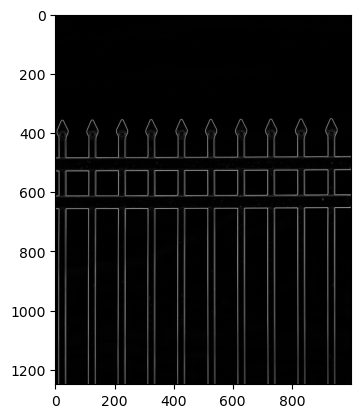

In [37]:
def get_sobel_kernels(ksize:int):
    kernel_x = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ])
    
    kernel_y = np.array([
        [ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]
    ])

    return kernel_x, kernel_y


def calc_gradient_custom(img:np.ndarray, ksize:int):
    ddepth = cv2.CV_64F
    
    k_x, k_y = get_sobel_kernels(ksize=ksize)
    grad_x = cv2.filter2D(img, ddepth, k_x)
    grad_y = cv2.filter2D(img, ddepth, k_y)
    # grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=ksize)
    # grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=ksize)

    magnitude = np.sqrt(np.square(grad_x) + np.square(grad_y))
    # ? Converting from rads to degrees
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi) 


    # ? Scaling the magnitude between 0 and 255
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min()) * 255
    return magnitude, angle 



magnitude, angle = calc_gradient_custom(blurred_img, KERNEL_SIZE)
cv2.imwrite('data/fence-edge-magnitude.jpg', magnitude)

plt.imshow(magnitude, cmap='gray')
plt.show()

## Step 4: Non Maximal Suppression

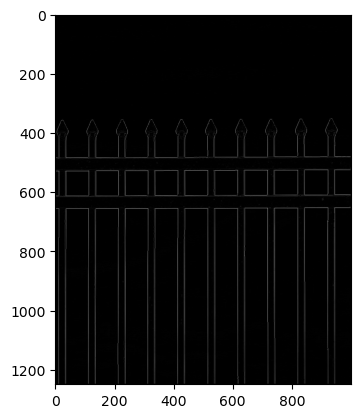

In [38]:
def non_maximal_custom(magnitude: np.ndarray, angle: np.ndarray):
    non_max = np.zeros_like(magnitude)

    # ? Only getting angles from 0 to 180 degrees
    angle = angle % 180

    # ? Angles are divided into 4 regions 
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            # Suppress pixels based on angle direction
            try:
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif 22.5 <= angle[i, j] < 67.5:
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif 67.5 <= angle[i, j] < 112.5:
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif 112.5 <= angle[i, j] < 157.5:
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]
                
                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    non_max[i, j] = magnitude[i, j]
                else:
                    non_max[i, j] = 0
            except IndexError:
                pass

    return non_max
    

non_max = non_maximal_custom(magnitude, angle)
cv2.imwrite('data/fence-nms.jpg', non_max)
plt.imshow(non_max, cmap='gray')
plt.show()

## Step 5: Double Thresholding

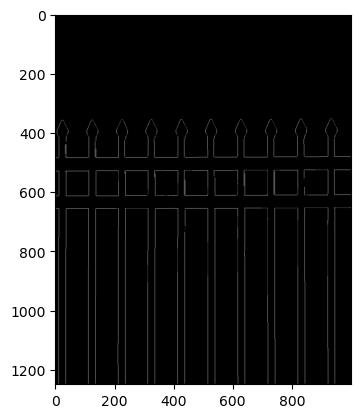

In [39]:
def double_thresh_custom(non_max: np.ndarray, thresh1:int, thresh2:int):
    # ? if inverted 
    if thresh1 > thresh2:
        thresh1, thresh2 = thresh2, thresh1

    res = np.zeros_like(non_max)
    strong_i, strong_j = np.where(non_max >= thresh2)
    weak_i, weak_j = np.where((non_max < thresh2) & (non_max > thresh1))

    res[strong_i, strong_j] = thresh1
    res[weak_i, weak_j] = thresh2

    return res 

# ? Setting thresholds the same as cv2.Canny
THRESH1 = 120
THRESH2 = 230
# TODO: problem starts with thresholding, find out why
# Might be an issue with the range of non_max
threshed_img = double_thresh_custom(non_max, THRESH1, THRESH2)

cv2.imwrite('data/fence-thresh.jpg', threshed_img)
plt.imshow(threshed_img, cmap='gray')
plt.show()

## Step 6: Hysteresis

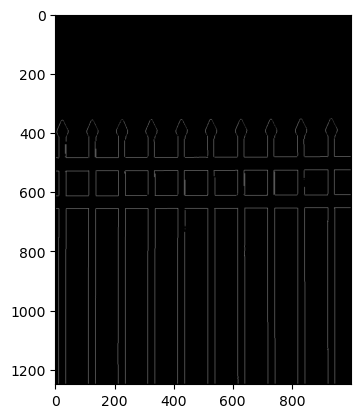

In [40]:
def hysteresis_custom(result:np.ndarray, thresh1, thresh2):
    if thresh1 > thresh2:
        thresh1, thresh2 = thresh2, thresh1

    for i in range(1, result.shape[0] - 1):
        for j in range(1, result.shape[1] - 1):
            if (result[i, j] == thresh1):
                if ((result[i+1, j-1:j+2] == thresh2).any() or (result[i-1, j-1:j+2] == thresh2).any() or 
                    (result[i, [j-1, j+1]] == thresh2).any()):
                    result[i, j] = thresh2
                else:
                    result[i, j] = 0
    
    result = result.astype(np.uint8)

    return result


custom_edges = hysteresis_custom(threshed_img, THRESH1, THRESH2)
cv2.imwrite('data/custom-canny.jpg', custom_edges)
plt.imshow(custom_edges, cmap='gray')
plt.show()

## Putting it all Together + Comparison with OpenCV

custom canny time taken: 0.94607s
opencv canny time taken: 0.00050s


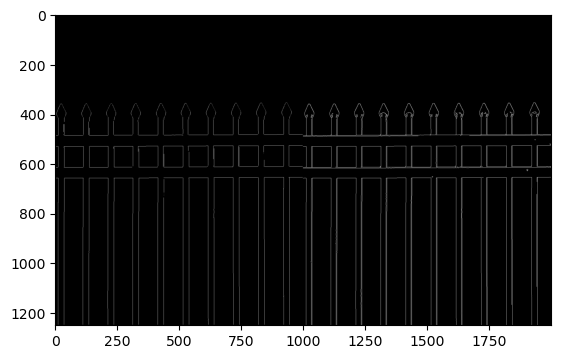

In [41]:
import time 
def canny_custom(img:np.ndarray, kernel_size:int, sigma:float=0.5, thresh1:int=THRESH1, thresh2:int=THRESH2):
    # 1. Convert to grayscale
    _img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Gaussian blur
    _blurred_img = gaussian_blur_custom(
        _img_gray,
        kernel_size=kernel_size,
        sigma=sigma
    )

    # 3. Compute Edges
    _magnitude, _angle = calc_gradient_custom(_blurred_img, kernel_size)

    # 4. Non Maximal Suppression
    _non_max = non_maximal_custom(_magnitude, _angle)

    # 5. Double Thresholding
    _threshed_img = double_thresh_custom(_non_max, thresh1, thresh2)

    # 6. Hysteresis
    _custom_edges = hysteresis_custom(_threshed_img, thresh1, thresh2)


    return _custom_edges

start_time = time.time()
custom_edges = canny_custom(
    img, KERNEL_SIZE
)
end_time = time.time()

print(f'custom canny time taken: {end_time - start_time:.5f}s')


start_time = time.time()
cv2_edges = cv2.Canny(blurred_img,THRESH1,THRESH2)
end_time = time.time()
print(f'opencv canny time taken: {end_time - start_time:.5f}s')
    

cv2.imwrite('data/fence-opencv-canny.jpg', cv2_edges)

res = np.hstack((custom_edges, cv2_edges))
plt.imshow(res, cmap='gray')
plt.show()

In [42]:
from math import log10, sqrt 

def mean_squared_error(x1, x2):
    '''
    Used to calculate the mse between original image and our implementation
    '''
    return np.mean(np.square(x1 - x2))


def psnr(x1, x2): 
    '''
    Peak Signal to Noise Ratio
    '''
    mse = mean_squared_error(x1, x2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

print(f'MSE between our implementation and OpenCV: {mean_squared_error(custom_edges, cv2_edges)}')
print(f'PSNR between our implementation and OpenCV: {psnr(custom_edges, cv2_edges)}')

# mean_squared_error(custom_edges, cv2_edges), psnr(custom_edges, cv2_edges)

MSE between our implementation and OpenCV: 1.7334656
PSNR between our implementation and OpenCV: 45.741651332074326


# Counting number of posts

## Naive Approach
We can just count the number of times a pixel is high on a horizontal line of the image in the range y = [800, 1200]

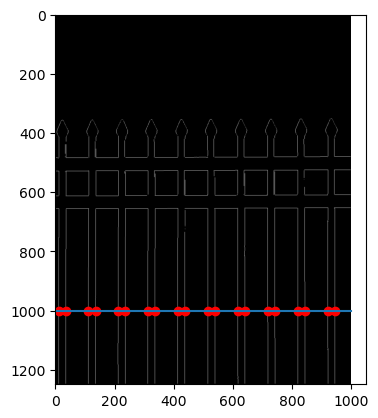

Total Posts: 10.0


In [69]:
def naive_count(edge_img:np.ndarray, y:int):
    line = edge_img[y, :]

    edge_points = np.where(line != 0)
    # line = line.reshape(-1, 1)
    return edge_points[0].tolist()


Y_ = 1000

edge_points = naive_count(custom_edges, Y_)

plt.imshow(custom_edges, cmap='gray')
plt.plot([0, Y_], [custom_edges.shape[1], Y_])

plt.scatter(edge_points, [Y_] * len(edge_points), color='r')
plt.show()

print(f'Total Posts: {len(edge_points) / 2}')

## Using HoughLines

total lines: 23


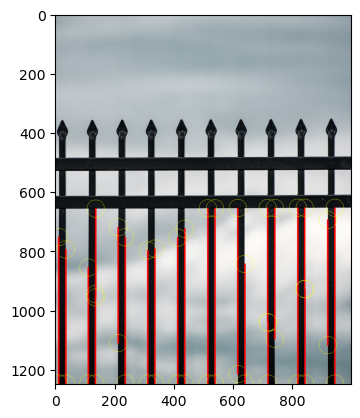

In [23]:
img = cv2.imread('data/fence.jpg')
MAX_LINE_GAP = 10
MIN_LINE_LENGTH = 200
HTHRESH=100

hlines = cv2.HoughLinesP(
    custom_edges, 1, np.pi/180, HTHRESH, minLineLength=MIN_LINE_LENGTH, maxLineGap=MAX_LINE_GAP
)

if hlines is not None:
    for i in range(0, len(hlines)):
        l = hlines[i][0]
        # print(l)
        cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
        cv2.circle(img, (l[0], l[1]), 30, (0, 255, 255))
        cv2.circle(img, (l[2], l[3]), 30, (0, 255, 255))



# TODO: Need to find a way to suppress these seperate lines into one line
# TODO: Maybe fiddle with threshold limits so that those lines are all classified as strong edges?
# TODO: Maybe join lines with endpoints in close proximity
print(f'total lines: {hlines.shape[0]}')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

(8, 1000, 3) 8


/var/folders/rm/r123ycgd171629307ltpkp000000gn/T/ipykernel_53740/868549253.py:33: RuntimeWarning: overflow encountered in scalar subtract
  vertical_lines = [line for line in lines if abs(line[0][0] - line[0][2]) < 10]  # Check for near-vertical lines


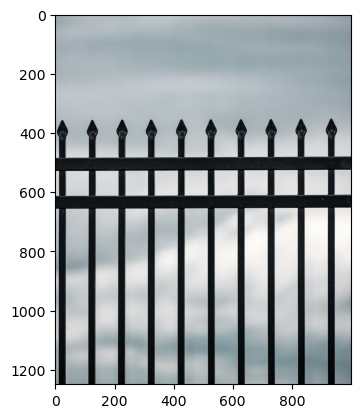

In [140]:
# def count_fence_posts(edge_image):
#     # Use the Hough Line Transform to detect vertical lines
#     lines = cv2.HoughLinesP(edge_image, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=10)
    
#     if lines is not None:
#         vertical_lines = [line for line in lines if abs(line[0][0] - line[0][2]) < 10]  # Check for near-vertical lines
        
#         # Count how many vertical lines
#         return len(vertical_lines)
#     return 0


# num_posts = count_fence_posts(custom_edges)
# print(num_posts)

def drawHoughLines(edge_image, img):
    # lines = cv2.HoughLinesP(custom_edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
        
    minLineLength = 600
    maxLineGap = 10
    linesP = cv2.HoughLinesP(
        edge_image,
        1,
        np.pi/180,
        225,
        minLineLength,
        maxLineGap
    )

    # linesP = cv2.HoughLinesP(edge_image, 1, np.pi / 180, threshold=100, minLineLength=600, maxLineGap=10)
    
    if linesP is not None:
        vertical_lines = [line for line in lines if abs(line[0][0] - line[0][2]) < 10]  # Check for near-vertical lines

    print(
        np.array(vertical_lines).shape, len(vertical_lines)
    )    
    linesP = vertical_lines

    # t = 0
    # if linesP is not None:
    #     for i in range(0, len(linesP)):
    #         l = linesP[i][0]
    #         print(l)
    #         t+=1
    #         cv2.line(img, (l[0], l[1]), (l[2], l[3]), (255), 3, cv2.LINE_AA)


    # print(t)
    return img 

# img = cv2.imread('data/fence.jpg')
# lines = drawHoughLines(custom_edges, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.imshow(lines, cmap='gray')